### Housekeeping

In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
Version info.
sys.version_info(major=3, minor=5, micro=3, releaselevel='final', serial=0)


In [48]:
import os
import pandas as pd
import random
import numpy as np
import librosa
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import datetime as datetime
import itertools
from collections import defaultdict
import random
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, precision_score, average_precision_score

import ibm_boto3
from ibm_botocore.client import Config, ClientError

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, optimizers, metrics, regularizers
from tensorflow.keras import backend as K

SEED = 101
random.seed(SEED)

print(tf.__version__)
print(tf.test.is_gpu_available())

1.15.2
False


### Loading files from bucket

In [3]:
DATA_PATH = '/home/csanc/'
BUCKET_NAME = 'cv-audio'

DATASET_PICKLE = 'mfcc/dataset.npz'

TEST_CLIPS = DATA_PATH + 'test-clips/'
BEST_MODEL_FILE = 'EN-TF1-Full-20200408-194433'

DATASET_SPLITS = 1

In [4]:
os.listdir(DATA_PATH)

['cuda-repo-ubuntu1604-10-1-local-10.1.168-418.67_1.0-1_amd64.deb',
 'OneShot_Speech_Carlos_EN-TF1-Full.ipynb',
 'nohup.out',
 '.gnupg',
 'dataset.npz',
 '.viminfo',
 'cuda-repo-ubuntu1604-10-1-local-10.1.105-418.39_1.0-1_amd64.deb',
 '.profile',
 '.bash_history',
 '.bashrc',
 '.ssh',
 '.ipynb_checkpoints',
 '.cache']

In [67]:
# Constants for IBM S3 values
COS_ENDPOINT = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'
COS_API_KEY_ID = 'LKRr_5OhOyBgvHG6WH2wm9F_2bHC2sn1vV4eaCYdgpsm'
COS_AUTH_ENDPOINT = 'https://iam.cloud.ibm.com/identity/token'
COS_RESOURCE_CRN = 'crn:v1:bluemix:public:cloud-object-storage:global:a/ea337a3eba2f43c6b813f319db505255:0f9730a8-f2b8-42ce-b276-f9e13877a5f0::'

# Create resource
cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [17]:
bucket = cos.Bucket(BUCKET_NAME)
obj = bucket.Object(DATASET_PICKLE)

with open(DATA_PATH + DATASET_PICKLE, 'wb') as data:
    obj.download_fileobj(data)

### Save files to the bucket

In [68]:
# Create resource
cos = ibm_boto3.client(
    service_name="s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [70]:
with open(DATA_PATH + 'checkpoints/model_en_full.tgz', 'rb') as data:
    cos.upload_fileobj(data, BUCKET_NAME, 'model_en_full.tgz')

In [71]:
cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

for file in cos.Bucket(BUCKET_NAME).objects.all():
    print("Item: {0} ({1} bytes).".format(file.key, file.size))

Item: EN-TF1-20200405-024254.tgz (50895219 bytes).
Item: dataset.npz (8414671607 bytes).
Item: dev-clips-wav.tgz (372144992 bytes).
Item: dev-clips.tgz (729032372 bytes).
Item: dev.tsv (3555470 bytes).
Item: en-clips.tgz (41357019402 bytes).
Item: mfcc.bin (499906808 bytes).
Item: model-EN-20200329-133052.tgz (152577527 bytes).
Item: model_en_full.tgz (129735130 bytes).
Item: test-clips.tgz (992056 bytes).
Item: test.tsv (3401154 bytes).
Item: test.txt (4 bytes).
Item: train.tsv (55941783 bytes).


### Loading MP3 files

In [8]:
def get_clip(file_name, max_pad_len=400):
    wave, sr = librosa.load(file_name, mono=True)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr) 

    pad_width = max_pad_len - mfcc.shape[1]
    
    if (pad_width < 0): 
        pad_width = 0
        mfcc = mfcc[:, 0:max_pad_len]
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.astype(np.float32)

### Create Model

In [17]:
DATA_PATH + DATASET_PICKLE

'/home/csanc/mfcc/dataset.npz'

In [18]:
dataset = np.load(DATA_PATH + DATASET_PICKLE)

In [19]:
left = dataset['left']
right = dataset['right']
labels = dataset['labels']
left.shape, right.shape, labels.shape

((671745, 20, 400, 1), (671745, 20, 400, 1), (671745,))

In [20]:
del(dataset)

In [21]:
dataset_size = left.shape[0]
train_size = int(dataset_size*0.7)
dataset_size, train_size

(671745, 470221)

In [12]:
def get_siamese_model():
  
    # Define the tensors for the two input images
    left_input = Input((20, 400, 1))
    right_input = Input((20, 400, 1))
    
    # Convolutional Neural Network
    model = models.Sequential()    
    model.add(layers.Conv2D(
        32, 
        (10,10), 
        padding = 'same',
        activation='relu', 
        input_shape=(20, 400, 1), 
        kernel_regularizer=regularizers.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        64, 
        (7,7),  
        padding = 'same',
        activation='relu',
        kernel_regularizer=regularizers.l2(2e-4)))    
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        64, 
        (4,4), 
        padding = 'same', 
        activation='relu', 
        kernel_regularizer=regularizers.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        128, 
        (4,4),  
        padding = 'same',
        activation='relu', 
        kernel_regularizer=regularizers.l2(2e-4)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        1024, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = models.Model(inputs=[left_input, right_input],outputs=prediction)
    
    # return the model
    return siamese_net

### Training

In [5]:
model = get_siamese_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 400, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20, 400, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         13408672    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambd

In [12]:
LR = 1e-4
model.compile(loss="binary_crossentropy", optimizer = optimizers.Adam(lr = LR))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#log_dir = DATA_PATH + 'logs/EN-TF1-' + now
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = DATA_PATH + 'checkpoints/EN-TF1-Full-' + now
checkpoints_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only=True,
    save_best_only = True,
    verbose=1)

In [14]:
print(checkpoint_path)
#print(log_dir)

/workspace/data/checkpoints/EN-TF1-Full-20200408-194433


In [ ]:
#left_train, left_val, right_train, right_val, labels_train, labels_val
#left[0:train_size]
#left[train_size:dataset_size]

#right[0:train_size]
#right[train_size:dataset_size]

#labels[0:train_size]
#labels[train_size:dataset_size]

In [15]:
BATCH = 512
EPOCHS = 200

history = model.fit(
   [left[0:train_size], right[0:train_size]], 
    labels[0:train_size], 
    batch_size = BATCH, 
    epochs = EPOCHS,
    validation_data = (
        [left[train_size:dataset_size],
         right[train_size:dataset_size]], 
        labels[train_size:dataset_size]),
    callbacks=[checkpoints_callback] #, tensorboard_callback
) 

Train on 470221 samples, validate on 201524 samples
Epoch 1/200
470016/470221 [============================>.] - ETA: 0s - loss: 0.4887
Epoch 00001: val_loss improved from inf to 0.23372, saving model to /workspace/data/checkpoints/EN-TF1-Full-20200408-194433
470221/470221 [==============================] - 301s 641us/sample - loss: 0.4885 - val_loss: 0.2337
Epoch 2/200
470016/470221 [============================>.] - ETA: 0s - loss: 0.1908
Epoch 00002: val_loss improved from 0.23372 to 0.16572, saving model to /workspace/data/checkpoints/EN-TF1-Full-20200408-194433
470221/470221 [==============================] - 185s 394us/sample - loss: 0.1907 - val_loss: 0.1657
Epoch 3/200
470016/470221 [============================>.] - ETA: 0s - loss: 0.1445
Epoch 00003: val_loss improved from 0.16572 to 0.13763, saving model to /workspace/data/checkpoints/EN-TF1-Full-20200408-194433
470221/470221 [==============================] - 178s 378us/sample - loss: 0.1445 - val_loss: 0.1376
Epoch 4/200
4

KeyboardInterrupt: 

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
with open(checkpoint_path + '-history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

### Inference

In [20]:
def get_accuracy(labels, predicted_scores, threshold=0.5):
    predicted = predicted_scores > threshold
    predicted = predicted.astype(int).ravel()
    return np.round(100*accuracy_score(labels, predicted), 2)

In [21]:
def plot_roc_auc(actual, predictions):
    fpr, tpr, roc_thresholds = roc_curve(actual, predictions)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC  = {:.3f}'.format(auc_value))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [22]:
def plot_precision_recall(actual, predictions):
    precision, recall, pr_thresholds = precision_recall_curve(actual, predictions)
    avg_precision = average_precision_score(actual, predictions)
    plt.plot(recall, precision, label='Avg Precision  = {:.3f}'.format(avg_precision))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.show()

In [16]:
checkpoint_path = '/home/csanc/checkpoints/EN-TF1-Full-20200408-194433/EN-TF1-Full-20200408-194433'

In [17]:
model = get_siamese_model()
model.load_weights(checkpoint_path)

#### Validation Set

In [28]:
left_val = left[train_size:dataset_size]
right_val = right[train_size:dataset_size]
labels_val = labels[train_size:dataset_size]

In [29]:
predicted_val = model.predict([left_val, right_val]).ravel()

In [30]:
#accuracy is a misleading metric here, we should look for the precision-recall
#plot and select a threshold that priviledges precision but does not cause a 
#too low recall
print('accuracy:', get_accuracy(labels_val, predicted_val))

accuracy: 98.72


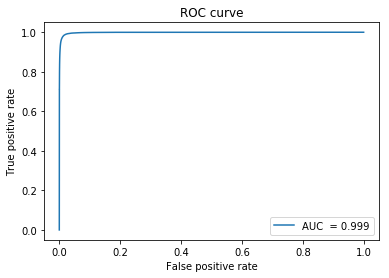

In [31]:
plot_roc_auc(labels_val, predicted_val)

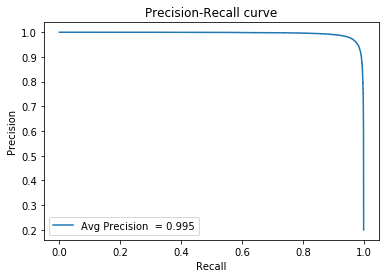

In [32]:
plot_precision_recall(labels_val, predicted_val)

#### Test Set

In [4]:
test_filenames = os.listdir(TEST_CLIPS)
test_filenames

['Xander_English_2.mp3',
 'Rose_Portuguese_3.m4a',
 'Other_Spanish_4.mp3',
 'Xander_English_5.m4a',
 'Xander_English_3.mp3',
 'Other_Spanish_5.mp3',
 'Xander_English_4.mp3',
 'Carlos_English_1.m4a',
 'Rose_Portuguese_1.m4a',
 'Other_Spanish_2.mp3',
 'Carlos_English_2.m4a',
 'Xander_English_1.mp3',
 'Other_Spanish_3.mp3',
 'Carlos_Portuguese_2.m4a',
 'Rose_Portuguese_2.m4a',
 'Rose_Portuguese_4.m4a',
 'Carlos_Portuguese_1.m4a',
 'Carlos_Portuguese_3.m4a',
 'Xander_English_6.m4a',
 'Other_Spanish_1.mp3',
 'Carlos_English_3.m4a',
 'Rose_Portuguese_5.m4a']

In [5]:
test_pairs = []
for a, b in itertools.combinations(test_filenames, 2):
    test_pairs.append([a, b, int(a[0:a.find('_')] == b[0:b.find('_')])])
test_pairs[0]

['Xander_English_2.mp3', 'Rose_Portuguese_3.m4a', 0]

In [13]:
def get_test_dataset():
    left = []
    right = []
    labels = [] 

    test_clips = {}
    for r in os.listdir(TEST_CLIPS):  
        test_path = TEST_CLIPS + r
        test_clips.update({r: get_clip(test_path)})

   
    for pair in test_pairs:       
        left.append([test_clips.get(pair[0])]) 
        right.append([test_clips.get(pair[1])])
        labels.append(np.float32(pair[2]))        
    
    left = np.array(left, dtype=np.float32)
    right = np.array(right, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    return left, right, labels

In [14]:
test_left, test_right, labels_test = get_test_dataset()
test_left.shape, test_right.shape, labels_test.shape

((231, 20, 400, 1), (231, 20, 400, 1), (231,))

In [18]:
predicted_test = model.predict([test_left, test_right]).ravel()

In [33]:
print('accuracy:', get_accuracy(labels_test, predicted_test))

accuracy: 90.48


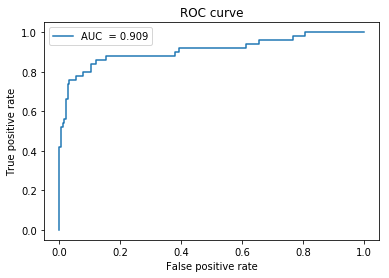

In [24]:
plot_roc_auc(labels_test, predicted_test)

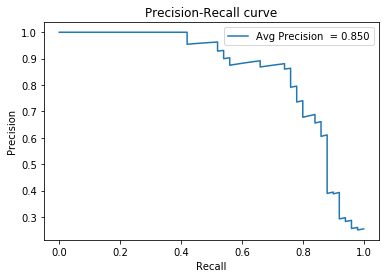

In [25]:
plot_precision_recall(labels_test, predicted_test)

In [29]:
test_df = pd.DataFrame(test_pairs, columns=['voice_a', 'voice_b', 'label'])
test_df['scores'] = predicted_test

In [65]:
false_positives = (test_df['scores'] > 0.5) & (test_df['label'] == 0)
test_df[false_positives]

,voice_a,voice_b,label,scores
53,Other_Spanish_4.mp3,Rose_Portuguese_4.m4a,0,0.778900
59,Other_Spanish_4.mp3,Rose_Portuguese_5.m4a,0,0.846316
111,Xander_English_4.mp3,Carlos_English_1.m4a,0,0.515904
169,Carlos_English_2.m4a,Rose_Portuguese_4.m4a,0,0.896482
175,Carlos_English_2.m4a,Rose_Portuguese_5.m4a,0,0.939520


In [66]:
false_negatives = (test_df['scores'] < 0.5) & (test_df['label'] == 1)
test_df[false_negatives]

,voice_a,voice_b,label,scores
3,Xander_English_2.mp3,Xander_English_3.mp3,1,1.185193e-01
5,Xander_English_2.mp3,Xander_English_4.mp3,1,3.469643e-01
57,Other_Spanish_4.mp3,Other_Spanish_1.mp3,1,3.249869e-01
60,Xander_English_5.m4a,Xander_English_3.mp3,1,4.013649e-02
79,Xander_English_3.mp3,Xander_English_4.mp3,1,4.506980e-01
84,Xander_English_3.mp3,Xander_English_1.mp3,1,4.832545e-02
91,Xander_English_3.mp3,Xander_English_6.m4a,1,1.592522e-01
122,Xander_English_4.mp3,Xander_English_6.m4a,1,4.836867e-01
131,Carlos_English_1.m4a,Carlos_Portuguese_2.m4a,1,3.684495e-01
134,Carlos_English_1.m4a,Carlos_Portuguese_1.m4a,1,1.722574e-05
